##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# MNIST classification

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/quantum/tutorials/mnist"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/quantum/blob/master/docs/tutorials/mnist.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/quantum/blob/master/docs/tutorials/mnist.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/quantum/docs/tutorials/mnist.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial builds a quantum neural network (QNN) to classify a simplified version of MNIST, similar to the approach used in <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al</a>. The performance of the quantum neural network on this classical data problem is compared with a classical neural network.

## Setup

In [ ]:
%%capture
!pip install tensorflow==2.3.1
!pip install tensorflow-quantum==0.4.0
!pip install qiskit
!pip install qsimcirq==0.9.0

Now import TensorFlow and the module dependencies:

In [ ]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections

#import qsimcirq

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

In [ ]:
tf.compat.v1.enable_eager_execution()
print(tf.executing_eagerly())

True


## 1. Load the data

In [ ]:
#from keras.preprocessing.image import ImageDataGenerator
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
training_set = train_datagen.flow_from_directory('drive/My Drive/Colab Notebooks/QCNN/bigger_dataset/training_set',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

Found 48389 images belonging to 2 classes.


In [ ]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory('drive/My Drive/Colab Notebooks/QCNN/bigger_dataset/test_set',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 12098 images belonging to 2 classes.


In [ ]:
from imblearn.over_sampling import RandomOverSampler
import numpy as np
import time as t
from sys import stdout

sm = RandomOverSampler(random_state=42)

x_train, y_train = next(training_set)
target_val = str(int(len(training_set))-1)
ti = t.time()
'''for i in range(int(len(training_set))-1): #1st batch is alread fetched before the for loop
    img, label = next(training_set)
    x_train = np.append(x_train, img, axis=0)
    y_train = np.append(y_train, label, axis=0)
    i += 1
    eti = int(t.time()-ti)
    k = str(i)+'/'+target_val+' - eta: +'+str((((eti/i)*int(target_val)) - eti)/3600)[:4]+'hrs - duration: '+str(eti)
    stdout.write("\r%s" % k)
    stdout.flush()
stdout.write("\n")'''

x_test, y_test = next(test_set)
'''target_val = str(int(len(test_set))-1)
ti = t.time()
for i in range(int(len(test_set))-1): #1st batch is alread fetched before the for loop
    img, label = next(test_set)
    x_test = np.append(x_test, img, axis=0 )
    y_test = np.append(y_test, label, axis=0)
    i += 1
    eti = int(t.time()-ti)
    k = str(i)+'/'+target_val+' - eta: +'+str((((eti/i)*int(target_val)) - eti)/3600)[:4]+'hrs - duration: '+str(eti)
    stdout.write("\r%s" % k)
    stdout.flush()
stdout.write("\n")'''

print(x_train.shape)
print(y_train.shape)

'''ry_train = np.reshape(y_train,(-1,1))
n_dim = ry_train.shape[0]
rx_train = np.reshape(x_train,(n_dim,-1))

print(rx_train.shape)
print(ry_train.shape)

x_train, y_train = None, None

x_smote, y_smote = sm.fit_resample(rx_train, ry_train)

x_smote = x_smote.reshape(-1, 64, 64, 3)
y_smote = y_smote.reshape(-1)

print(x_smote.shape)
print(y_smote.shape)

x_train = x_smote
y_train = y_smote'''

print("Augmented number of training examples:", len(x_train))
print("Number of test examples:", len(x_test))

(32, 64, 64, 3)
(32,)
Augmented number of training examples: 32
Number of test examples: 32


1.0


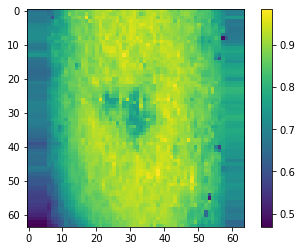

In [ ]:
print(y_train[0])

plt.imshow(x_train[0,:,:,2])
plt.colorbar()

### 1.3 Encode the data as quantum circuits

To process images using a quantum computer, <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> proposed representing each pixel with a qubit, with the state depending on the value of the pixel. The first step is to convert to a binary encoding.

In [ ]:
THRESHOLD = 0.5

x_train_bin = np.array(x_train > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test > THRESHOLD, dtype=np.float32)

In [ ]:
from qiskit import *

def create_1q3a_rotation(bit, registers, params, iter_list):
    try:
        _ = params[0]
    except(IndexError):
        print('Error Expected: empty params passed at iteration variable positions i,j:',iter_list)

    circuit = QuantumCircuit(registers[0], registers[1])

    circuit.rx(params[0], bit)
    circuit.ry(params[1], bit)
    circuit.rz(params[2], bit)

    return circuit

def create_rzz_gate(bits, registers, param):
    circuit = QuantumCircuit(registers[0], registers[1])

    circuit.cx(bits[0],bits[1])
    circuit.rz(param, bits[1])
    circuit.cx(bits[0],bits[1])

    return circuit

def create_ryy_gate(bits, registers, param):

    circuit = QuantumCircuit(registers[0], registers[1])

    circuit.rx(np.pi/2, bits[0])
    circuit.rx(np.pi/2, bits[1])
    circuit.cx(bits[0], bits[1])
    circuit.rz(param, bits[1])
    circuit.cx(bits[0], bits[1])
    circuit.rx(-np.pi/2, bits[0])
    circuit.rx(-np.pi/2, bits[1])

    return circuit

def create_rxx_gate(bits, registers, param):

    circuit = QuantumCircuit(registers[0], registers[1])

    circuit.h(bits[0])
    circuit.h(bits[1])
    circuit.cx(bits[0], bits[1])
    circuit.rz(param, bits[1])
    circuit.cx(bits[0], bits[1])
    circuit.h(bits[0])
    circuit.h(bits[1])

    return circuit

def create_2q3a_rotation(bits, registers, params, iter_list):
    try:
        _ = params[0]
    except():
        print('Error Expected: empty params passed at iteration variable positions i,j:',iter_list)

    circuit = QuantumCircuit(registers[0], registers[1])

    circuit += create_1q3a_rotation(bits[0], registers, params[0:3], iter_list)
    circuit += create_1q3a_rotation(bits[1], registers, params[3:6], iter_list)

    circuit += create_rzz_gate(bits, registers, params[6])
    circuit += create_ryy_gate(bits, registers, params[7])
    circuit += create_rxx_gate(bits, registers, params[8])

    circuit += create_1q3a_rotation(bits[0], registers, params[9:12], iter_list)
    circuit += create_1q3a_rotation(bits[1], registers, params[12:], iter_list)
    
    return circuit

def create_pooling_circuit(bits, registers, params, iter_list):
    circuit = QuantumCircuit(registers[0], registers[1])

    circuit += create_1q3a_rotation(bits[0], registers, params[3:6], iter_list)
    circuit += create_1q3a_rotation(bits[1], registers, params[0:3], iter_list)
    circuit.cx(bits[1],bits[0])
    circuit.rz(-1*params[2], bits[1])
    circuit.ry(-1*params[1], bits[1])
    circuit.rx(-1*params[0], bits[1])

    return circuit

In [ ]:
def image_to_circuit(image, iter_list):
    values = np.ndarray.flatten(image)
    qr = QuantumRegister(16)
    cr = ClassicalRegister(16)
    img_circ = QuantumCircuit(qr, cr)

    for i in range(0,16,2):
        img_circ += create_2q3a_rotation([i,i+1],[qr,cr],values[0:15], iter_list)
    for i in range(1,15,2):
        img_circ += create_2q3a_rotation([i,i+1],[qr,cr],values[0:15], iter_list)
    img_circ += create_2q3a_rotation([0,15],[qr,cr],values[0:15], iter_list)

    return [img_circ, qr, cr]

def add_pooling(encoded_data, params, iter_list):
    values = params[:]
    img_circ = encoded_data[0]
    qr = encoded_data[1]
    cr = encoded_data[2]

    for i in range(0,16,2):
        img_circ += create_pooling_circuit([i,i+1],[qr,cr],values[0 + 3 * i:6 + 3 * i], iter_list)
    for i in range(1,16,4):
        img_circ += create_pooling_circuit([i,i+2],[qr,cr],values[48 + int(1.5 * (i-1)):54 + int(1.5 * (i-1))], iter_list)
    for i in range(3,16,8):
        img_circ += create_pooling_circuit([i,i+4],[qr,cr],values[72 + int(0.75 * (i-3)):78 + int(0.75 * (i-3))], iter_list)
    img_circ += create_pooling_circuit([7,15],[qr,cr],values[84:90], iter_list)

    qasm_vers = img_circ.qasm()[:-1]
    n = qasm_vers[-20:][qasm_vers[-20:].find('q')+1:qasm_vers[-20:].find('[')]
    qasm_vers += '\nmeasure q'+n+'[15] -> c'+n+'[15];'
    from cirq.contrib.qasm_import import circuit_from_qasm
    cirq_vers = circuit_from_qasm(qasm_vers)

    return cirq_vers

In [ ]:
!pip install cirq==0.9.1

In [ ]:
from numba import njit, prange
import qsimcirq

class qconv_64x64_trainable (tf.keras.layers.Layer):
    def __init__(self, encoder, pooler):
        super(qconv_64x64_trainable, self).__init__()
        self.encode_data = encoder
        self.pool = pooler
        self.simulator = qsimcirq.QSimSimulator()

    def build(self, input_shape):
        self.kernel = self.add_weight("kernel",
                                  shape=[100,1])

    def call(self, input):
        tf.compat.v1.enable_eager_execution()
        print(tf.executing_eagerly())

        return np.array([[self.simulator.run(self.pool(self.encode_data(input.numpy()[j:j+4,i:i+4], [i,j]), [self.kernel[n].numpy()[0] for n in range(100)], [i,j])).data.iat[0,0] for i in range(input.shape[0]-3)] for j in range(input.shape[1]-3)])

        #result = np.empty([61,61])
        #for j in prange(0,input.shape[1]-3):
        #    for i in prange(0,input.shape[0]-3):
        #        print('input:',input,input.numpy())
        #        image_segment = input[0][j:j+4,i:i+4]
        #        iss_encoded_data = self.encode_data(image_segment)
        #        tbt_cirq_full = self.pool(iss_encoded_data, [self.kernel[i].numpy()[0] for i in range(90)])
        #        res = self.simulator.run(tbt_cirq_full).data.iat[0,0]
        #        result[j,i] = res
        #return np.array([[result]])

In [ ]:
model = tf.keras.Sequential()
model.add(qconv_64x64_trainable(image_to_circuit, add_pooling))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[61, 61]))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=256, activation='relu'))
model.add(tf.keras.layers.Dense(units=256, activation='relu'))
model.add(tf.keras.layers.Dense(units=256, activation='relu'))
model.add(tf.keras.layers.Dense(units=256, activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [ ]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.Accuracy()])

In [ ]:
print(tf.executing_eagerly())
tf.config.run_functions_eagerly(True)
qnn_history = model.fit(
      x_train_bin, y_train,
      batch_size=32,
      epochs=5,
      verbose=1,
      validation_data=(x_test_bin, y_test))

qnn_results = model.evaluate(x_test_bin, y_test)

True
Epoch 1/5
True


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


IndexError: ignored